In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/ocean/pro

In [12]:
metacell_adata = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/seacells_F_FastIIB.h5ad'
adata = sc.read_h5ad(metacell_adata)

In [13]:
adata

AnnData object with n_obs × n_vars = 213 × 4000
    obs: 'y'

#### Sparsity based gene filtering

In [9]:
import numpy as np
from scipy.sparse import issparse

def calculate_zero_proportion(adata, axis='genes'):
    """
    Calculate the proportion of zeros for either genes (features) or cells in an AnnData object.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing gene expression data
    axis : str, default 'genes'
        Which axis to calculate zeros for:
        - 'genes' or 'features' or 'columns': calculate zeros per gene (column-wise)
        - 'cells' or 'rows': calculate zeros per cell (row-wise)
        
    Returns:
    --------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each gene or cell
    """
    if axis.lower() in ['genes', 'features', 'columns']:
        # Calculate zeros per gene (column-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_cells = adata.n_obs
            non_zero_per_gene = np.array((adata.X != 0).sum(axis=0)).flatten()
            zero_per_gene = n_cells - non_zero_per_gene
            proportion_zeros = zero_per_gene / n_cells
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=0) / adata.n_obs
            
    elif axis.lower() in ['cells', 'rows']:
        # Calculate zeros per cell (row-wise)
        if issparse(adata.X):
            # For sparse matrix: count non-zeros, then calculate zeros
            n_genes = adata.n_vars
            non_zero_per_cell = np.array((adata.X != 0).sum(axis=1)).flatten()
            zero_per_cell = n_genes - non_zero_per_cell
            proportion_zeros = zero_per_cell / n_genes
        else:
            # For dense matrix
            proportion_zeros = (adata.X == 0).sum(axis=1) / adata.n_vars
    else:
        raise ValueError("axis must be 'genes', 'features', 'columns', 'cells', or 'rows'")
    
    return proportion_zeros

def plot_sparsity_analysis(proportion_zeros, str='features', figsize=(14, 5), bins=50, 
                                color='steelblue', alpha=0.7, show_stats=True):
    """
    Plot cell/feature sparsity analysis with histogram and cumulative distribution.
    
    Parameters:
    -----------
    proportion_zeros : numpy.ndarray
        Array containing the proportion of zeros for each feature/cell
    figsize : tuple, default (14, 5)
        Figure size for the plots
    bins : int, default 50
        Number of bins for the histogram
    color : str, default 'steelblue'
        Color for the histogram bars
    alpha : float, default 0.7
        Transparency for the histogram bars
    show_stats : bool, default True
        Whether to print summary statistics
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    axes : numpy.ndarray
        Array of axes objects
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot 1: Histogram of cell/feature sparsity
    axes[0].hist(proportion_zeros, bins=bins, edgecolor='black', alpha=alpha, color=color)
    axes[0].set_xlabel('Proportion of zeros')
    axes[0].set_ylabel('Number of ' + str)
    axes[0].set_title('Sparsity')
    axes[0].axvline(proportion_zeros.mean(), color='red', linestyle='--', 
                    label=f'Mean = {proportion_zeros.mean():.2f}')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Plot 2: Cumulative distribution
    sorted_props = np.sort(proportion_zeros)
    cumulative = np.arange(1, len(sorted_props) + 1) / len(sorted_props)
    axes[1].plot(sorted_props, cumulative, linewidth=2)
    axes[1].set_xlabel('Proportion of zeros')
    axes[1].set_ylabel('Cumulative fraction of ' + str)
    axes[1].set_title('Cumulative Distribution of Sparsity')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    if show_stats:
        print(f"Total {str}: {len(proportion_zeros)}")
        print(f"Mean proportion of zeros: {proportion_zeros.mean():.3f}")
        print(f"Median proportion of zeros: {np.median(proportion_zeros):.3f}")
        print(f"\n{str} by sparsity:")
        print(f"  >95% zeros: {(proportion_zeros > 0.95).sum()} {str} ({(proportion_zeros > 0.95).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >94% zeros: {(proportion_zeros > 0.94).sum()} {str} ({(proportion_zeros > 0.94).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  >90% zeros: {(proportion_zeros > 0.90).sum()} {str} ({(proportion_zeros > 0.90).sum()/len(proportion_zeros)*100:.1f}%)")
        print(f"  All zeros:  {(proportion_zeros == 1.0).sum()} {str}")
    
    return fig, axes


In [14]:
proportion_zeros_feature = calculate_zero_proportion(adata, axis='features')

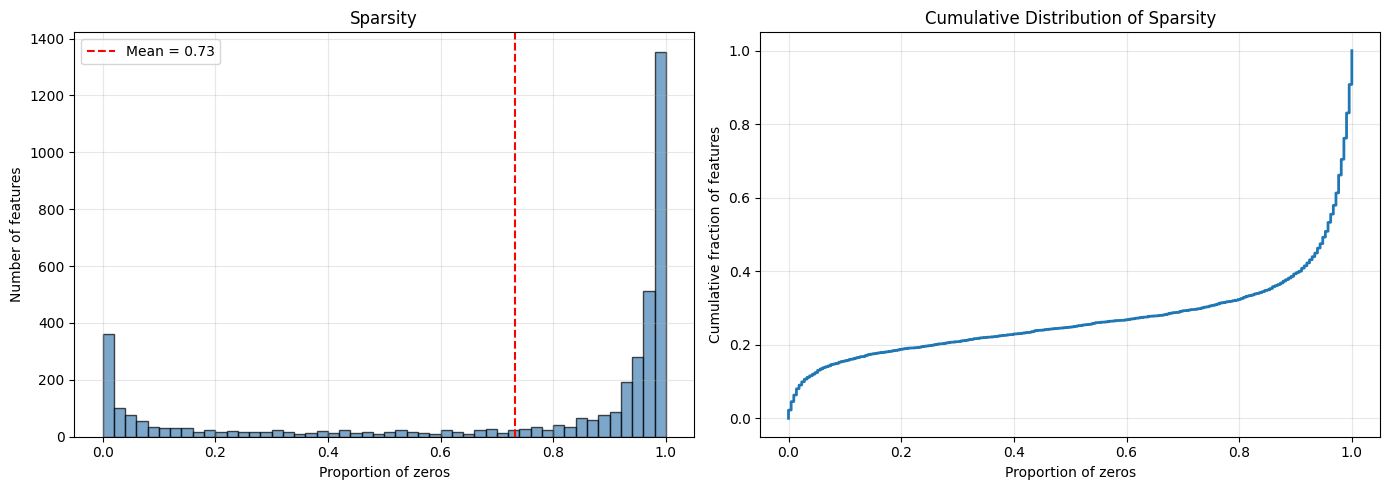

Total features: 4000
Mean proportion of zeros: 0.731
Median proportion of zeros: 0.953

features by sparsity:
  >95% zeros: 2029 features (50.7%)
  >94% zeros: 2148 features (53.7%)
  >90% zeros: 2429 features (60.7%)
  All zeros:  368 features


In [15]:
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

In [16]:
# Remove genes with all zeros
genes_to_keep = proportion_zeros_feature < 0.8

print(f"Before filtering: {adata.n_vars} genes")
adata_filtered = adata[:, genes_to_keep]
print(f"After filtering: {adata_filtered.n_vars} genes")
print(f"Removed: {(~genes_to_keep).sum()} genes")

Before filtering: 4000 genes
After filtering: 1293 genes
Removed: 2707 genes


### Filtering for slide

#### Subset to cell type of interest

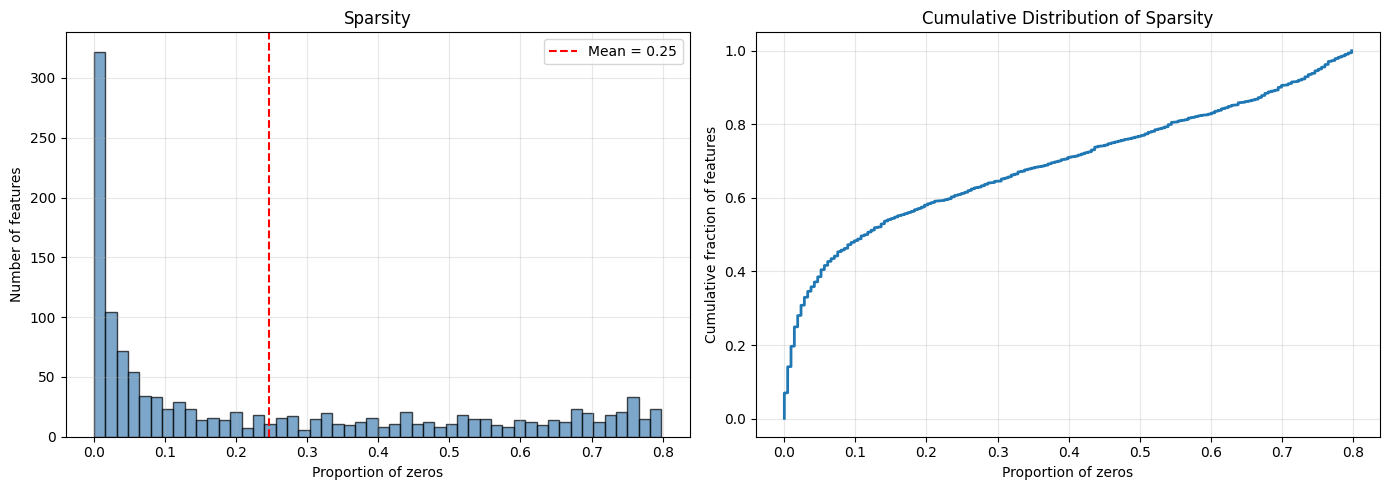

Total features: 1293
Mean proportion of zeros: 0.246
Median proportion of zeros: 0.117

features by sparsity:
  >95% zeros: 0 features (0.0%)
  >94% zeros: 0 features (0.0%)
  >90% zeros: 0 features (0.0%)
  All zeros:  0 features


In [17]:
proportion_zeros_feature = calculate_zero_proportion(adata_filtered, axis='features')
# Plot the analysis
fig, axes = plot_sparsity_analysis(proportion_zeros_feature, str='features')

### Variance filtering of features

/tmp/ipykernel_26484/2609563064.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_filtered.var['variance'] = gene_variance


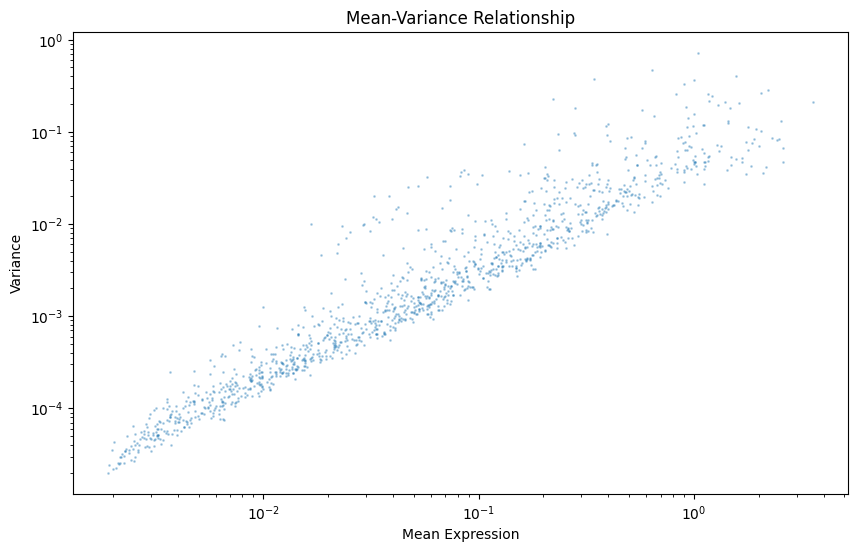

In [18]:
# Calculate mean and variance for each gene
gene_mean = np.mean(adata_filtered.X.toarray() if hasattr(adata_filtered.X, 'toarray') else adata_filtered.X, axis=0)
gene_variance = np.var(adata_filtered.X.toarray() if hasattr(adata_filtered.X, 'toarray') else adata_filtered.X, axis=0)

# Add variance to adata.var for easy access
adata_filtered.var['variance'] = gene_variance

plt.figure(figsize=(10, 6))
plt.scatter(gene_mean, gene_variance, alpha=0.3, s=1)
plt.xlabel('Mean Expression')
plt.ylabel('Variance')
plt.title('Mean-Variance Relationship')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
display(type(adata_filtered.obs))

pandas.core.frame.DataFrame

In [26]:
adata_df = pd.DataFrame(adata_filtered.X, index=adata_filtered.obs_names, columns=adata_filtered.var_names)
adata_df

,2610203C22Rik,Slco5a1,Stau2,Jph1,Gdap1,Kcnq5,Gm29506,Adgrb3,Cox5b,4933424G06Rik,...,Rai2,Nhs,Pir,Asb11,Arhgap6,Gm15261,Gm15246,Mid1,Gm47283,Tmlhe
SEACell,,,,,,,,,,,,,,,,,,,,,
0_F15_WT,0.040670,0.267362,0.218382,2.180222,0.310442,0.720336,0.000000,0.000000,0.000000,0.011896,...,0.052384,0.004589,0.062950,0.333913,0.975650,0.205820,0.020061,0.252605,0.537429,0.144679
0_F3_WT,0.011047,0.286980,0.356813,1.622901,0.088860,0.963576,0.007081,0.002465,0.002977,0.010028,...,0.079389,0.007463,0.031786,0.396656,0.954650,0.052342,0.005443,0.117752,0.556557,0.143323
0_F4_WT,0.000000,0.109921,0.373556,1.937005,0.148678,0.494109,0.016736,0.014037,0.000000,0.000000,...,0.060340,0.019664,0.019737,0.210383,0.976974,0.056067,0.006460,0.055888,0.338220,0.082593
0_F706_KO,0.015450,0.282232,0.491834,1.709481,0.126411,0.649824,0.005463,0.000983,0.000714,0.011207,...,0.098281,0.007485,0.049907,0.379036,0.844037,0.055830,0.008748,0.120583,0.287184,0.163739
0_F785_KO,0.023157,0.382259,0.215554,1.967712,0.096198,0.601644,0.012119,0.000000,0.017236,0.036549,...,0.060828,0.000000,0.079646,0.350555,1.216046,0.054224,0.000000,0.105040,0.403584,0.174580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_F3_WT,0.004776,0.321210,0.314785,1.713518,0.093725,0.459173,0.000000,0.000000,0.000000,0.007674,...,0.131681,0.019819,0.040132,0.473703,1.093114,0.047788,0.015069,0.194611,0.538639,0.105478
9_F4_WT,0.000000,0.466798,0.427821,1.773041,0.087917,0.775481,0.000000,0.000000,0.000000,0.000000,...,0.062050,0.022506,0.027847,0.464379,0.838672,0.018926,0.000000,0.181442,0.537281,0.154245
9_F706_KO,0.028604,0.328335,0.507158,1.792224,0.142604,0.264009,0.039204,0.000000,0.000000,0.000000,...,0.103195,0.025768,0.026244,0.384293,1.064558,0.054839,0.000000,0.168026,0.233710,0.161938


In [28]:
# Sort Y by Class
Y_sorted = adata_filtered.obs.sort_values('y', ascending=True)

# Reorder adata_df to match the same order
adata_df_sorted = adata_df.loc[Y_sorted.index]

# Verify the order is synchronized
print("Y sorted:")
display(Y_sorted)
print(f"\nKO samples (Class=1): {(Y_sorted['y'] == 1).sum()}")
print(f"WT samples (Class=0): {(Y_sorted['y'] == 0).sum()}")

print("\nX matrix sorted:")
display(adata_df_sorted)

# Verify indices match
print(f"\nIndices match: {(Y_sorted.index == adata_df_sorted.index).all()}")

Y sorted:


,y
SEACell,
0_F15_WT,0
27_F15_WT,0
27_F3_WT,0
28_F15_WT,0
28_F3_WT,0
...,...
29_F706_KO,1
16_F785_KO,1
16_F7_KO,1



KO samples (Class=1): 105
WT samples (Class=0): 108

X matrix sorted:


,2610203C22Rik,Slco5a1,Stau2,Jph1,Gdap1,Kcnq5,Gm29506,Adgrb3,Cox5b,4933424G06Rik,...,Rai2,Nhs,Pir,Asb11,Arhgap6,Gm15261,Gm15246,Mid1,Gm47283,Tmlhe
SEACell,,,,,,,,,,,,,,,,,,,,,
0_F15_WT,0.040670,0.267362,0.218382,2.180222,0.310442,0.720336,0.000000,0.000000,0.000000,0.011896,...,0.052384,0.004589,0.062950,0.333913,0.975650,0.205820,0.020061,0.252605,0.537429,0.144679
27_F15_WT,0.033500,0.155244,0.186377,2.076779,0.262443,0.618126,0.000000,0.000000,0.000000,0.015775,...,0.101757,0.000000,0.035142,0.203859,0.792773,0.252498,0.026992,0.244631,0.761988,0.114874
27_F3_WT,0.000000,0.313642,0.193575,1.650289,0.056426,0.661169,0.000000,0.000000,0.115704,0.037860,...,0.171533,0.000000,0.031991,0.461838,0.840323,0.037403,0.000000,0.200592,0.455398,0.157796
28_F15_WT,0.024882,0.292707,0.326095,1.903584,0.170128,0.943323,0.005834,0.005342,0.000000,0.035646,...,0.156642,0.011674,0.081813,0.338057,0.942248,0.237773,0.012736,0.223360,0.529146,0.146937
28_F3_WT,0.000000,0.449572,0.433985,1.999751,0.084424,1.020460,0.042265,0.000000,0.000000,0.000000,...,0.256255,0.000000,0.000000,0.261426,1.346246,0.047129,0.026114,0.187851,0.412105,0.221369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29_F706_KO,0.046054,0.506292,0.757822,1.756137,0.044268,0.918317,0.000000,0.010995,0.000000,0.045477,...,0.084270,0.007558,0.038585,0.349719,0.928597,0.065490,0.000000,0.135125,0.206910,0.187406
16_F785_KO,0.006568,0.351826,0.212363,1.848602,0.080199,0.619599,0.000000,0.000000,0.278320,0.017308,...,0.068074,0.025488,0.033601,0.294077,0.814942,0.064629,0.015415,0.112895,0.369256,0.060088
16_F7_KO,0.049799,0.224455,0.567161,1.997654,0.165154,0.276295,0.000000,0.000000,0.000000,0.050915,...,0.080227,0.026538,0.104744,0.121917,0.541405,0.095837,0.000000,0.167307,0.933671,0.059894



Indices match: True


In [29]:
# Update the original variables
Y = Y_sorted
adata_df = adata_df_sorted

In [30]:
#save to csv
out_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples"
adata_df.to_csv(os.path.join(out_dir, 'female_fast2b_X.csv'))

In [31]:
# save to csv
Y.to_csv(os.path.join(out_dir, 'female_fast2b_Y.csv'))

## Run slide

In [32]:
import loveslide
from loveslide import OptimizeSLIDE

/ocean/projects/cis240075p/asachan/.conda/envs/loveslide_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
During startup - Warning messages:
1: package ‘methods’ was built under R version 4.4.3 
2: package ‘datasets’ was built under R version 4.4.3 
3: package ‘utils’ was built under R version 4.4.3 
4: package ‘grDevices’ was built under R version 4.4.3 
5: package ‘graphics’ was built under R version 4.4.3 
6: package ‘stats’ was built under R version 4.4.3 


In [33]:
input_params = {
    'x_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_X.csv',
    'y_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_Y.csv',
    'fdr': 0.1,
    'thresh_fdr': 0.1,
    'spec': 0.2,
    'y_factor': True,
    'niter': 500,
    'SLIDE_top_feats': 20,
    'rep_CV': 50,
    'pure_homo': True,
    'delta': [0.01],
    'lambda': [0.5, 0.1],
    'out_path': '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/female/slide_outs/fast2b'
}

In [ ]:
slider = OptimizeSLIDE(input_params)
slider.run_pipeline(verbose=True, n_workers=1)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package ‘tools’ was built under R version 4.4.3 




### PARAMETERS ###

x_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_X.csv
y_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_fast2b_Y.csv
fdr: 0.1
thresh_fdr: 0.1
spec: 0.2
y_factor: True
niter: 500
SLIDE_top_feats: 20
rep_CV: 50
pure_homo: True
delta: [0.01]
lambda: [0.5, 0.1]
out_path: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/female/slide_outs/fast2b
n_workers: 1
do_interacts: True

###### DATA ######

213 samples
1293 features
49.3% cases
50.7% controls

##################

Running LOVE with delta=0.01 and lambda=0.5
LOVE found 106 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 106
Finding standalone LF...


Processing subsets: 100%|██████████| 1/1 [06:49<00:00, 409.10s/it]


Found 1 standalone LF
Finding interacting LF...


Processing subsets: 100%|██████████| 1/1 [11:02<00:00, 662.14s/it]


Found 2 interacting LF

SLIDE complete.

Completed 0.01_0.5

##################

Running LOVE with delta=0.01 and lambda=0.1
LOVE found 106 latent factors.

Running SLIDE knockoffs...
Calculated f_size: 106
Finding standalone LF...


Processing subsets:   0%|          | 0/1 [00:00<?, ?it/s]